In [1]:
!pip install mne
!pip install pywavelets
!pip install matplotlib
!pip install numpy
!pip install pandas
!pip install tensorflow
!pip install scikit-learn  # Note: 'sklearn' is the package name, but we install 'scikit-learn'
!pip install keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 53.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 22.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 3.7 MB/s eta 0:00:00


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import mne
from mne.datasets import eegbci
from mne.io import read_raw_edf
import os
from tqdm import tqdm
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
import keras_tuner as kt



In [3]:
np.random.seed(42)
subjects = range(1, 10)  # 9 subjects as previously modified
runs = [4, 8, 12]

# Preprocessing parameters
samplingFreq = 160
lowFreq = 0.5
highFreq = 45
notchFreq = 60
tMin, tMax = 0, 4

def loadEEG(subject, runs):
    filePaths = eegbci.load_data(subject, runs)
    print(f"Loading data for subject {subject}")
    rawlist = []

    for file in filePaths:
        raw = read_raw_edf(file, preload=True)
        rawlist.append(raw)

    if len(rawlist) > 1:
        raw = mne.concatenate_raws(rawlist)
    else:
        raw = rawlist[0]

    rename_dict = {
        'Fc5.': 'FC5', 'Fc3.': 'FC3', 'Fc1.': 'FC1', 'Fcz.': 'FCz', 'Fc2.': 'FC2', 'Fc4.': 'FC4', 'Fc6.': 'FC6',
        'C5..': 'C5', 'C3..': 'C3', 'C1..': 'C1', 'Cz..': 'Cz', 'C2..': 'C2', 'C4..': 'C4', 'C6..': 'C6',
        'Cp5.': 'CP5', 'Cp3.': 'CP3', 'Cp1.': 'CP1', 'Cpz.': 'CPz', 'Cp2.': 'CP2', 'Cp4.': 'CP4', 'Cp6.': 'CP6',
        'Fp1.': 'Fp1', 'Fpz.': 'Fpz', 'Fp2.': 'Fp2', 'Af7.': 'AF7', 'Af3.': 'AF3', 'Afz.': 'AFz', 'Af4.': 'AF4', 'Af8.': 'AF8',
        'F7..': 'F7', 'F5..': 'F5', 'F3..': 'F3', 'F1..': 'F1', 'Fz..': 'Fz', 'F2..': 'F2', 'F4..': 'F4', 'F6..': 'F6', 'F8..': 'F8',
        'Ft7.': 'FT7', 'Ft8.': 'FT8', 'T7..': 'T7', 'T8..': 'T8', 'T9..': 'T9', 'T10.': 'T10', 'Tp7.': 'TP7', 'Tp8.': 'TP8',
        'P7..': 'P7', 'P5..': 'P5', 'P3..': 'P3', 'P1..': 'P1', 'Pz..': 'Pz', 'P2..': 'P2', 'P4..': 'P4', 'P6..': 'P6', 'P8..': 'P8',
        'Po7.': 'PO7', 'Po3.': 'PO3', 'Poz.': 'POz', 'Po4.': 'PO4', 'Po8.': 'PO8', 'O1..': 'O1', 'Oz..': 'Oz', 'O2..': 'O2', 'Iz..': 'Iz'
    }
    raw.rename_channels(rename_dict)

    montage = mne.channels.make_standard_montage('standard_1020')
    raw.set_montage(montage)

    events, eventID = mne.events_from_annotations(raw)
    raw.filter(l_freq=lowFreq, h_freq=highFreq)
    raw.notch_filter(freqs=notchFreq)

    eventID = dict(T1=1, T2=2)
    epochs = mne.Epochs(raw, events, eventID, tmin=tMin, tmax=tMax, baseline=None, preload=True)
    return raw, epochs, events, eventID

In [4]:
# Initialize data storage
allData = []
allLabels = []

# Process each subject
for subject in subjects:
    try:
        print(f"\n{'='*50}\nProcessing subject {subject}\n{'='*50}")
        raw, epochs, events, eventID = loadEEG(subject, runs)

        print(f"Subject {subject} data loaded successfully")
        print(f"Number of channels: {len(raw.ch_names)}")
        print(f"Number of epochs: {len(epochs)}")
        print(f"Sampling frequency: {raw.info['sfreq']} Hz")
        print(f"Duration: {raw.times.max()} seconds")

        # Extract raw epoched data and labels
        data = epochs.get_data()  # Shape: (n_epochs, n_channels, n_times)
        labels = epochs.events[:, -1]  # Shape: (n_epochs,)

        allData.append(data)
        allLabels.append(labels)

        print(f"Data shape for subject {subject}: {data.shape}")
        print(f"Labels: {np.unique(labels, return_counts=True)}")

    except Exception as e:
        print(f"Error processing subject {subject}: {e}")
        continue


Processing subject 1
Using default location ~/mne_data for EEGBCI...
Creating /root/mne_data


Do you want to set the path:
    /root/mne_data
as the default EEGBCI dataset path in the mne-python config [y]/n? Y
Attempting to create new mne-python configuration file:
/root/.mne/mne-python.json
Download complete in 28s (7.4 MB)
Loading data for subject 1
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Used Annotati

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 3 contiguous segments
Setting up band-stop filter from 59 - 61 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 59.35
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 59.10 Hz)
- Upper passband edge: 60.65 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 60.90 Hz)
- Filter length: 1057 samples (6.606 s)

Setting up band-stop filter from 59 - 61 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 59.35
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 59.10 Hz)
- Upper passband edge: 60.65 Hz
- Upper transition bandwidth

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Setting up band-stop filter from 59 - 61 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 59.35
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 59.10 Hz)
- Upper passband edge: 60.65 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 60.90 Hz)
- Filter length: 1057 samples (6.606 s)

Not setting metadata
68 matching events found


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 68 events and 641 original time points ...
0 bad epochs dropped
Subject 1 data loaded successfully
Number of channels: 64
Number of epochs: 68
Sampling frequency: 160.0 Hz
Duration: 374.99375 seconds
Data shape for subject 1: (68, 64, 641)
Labels: (array([1, 2]), array([45, 23]))

Processing subject 2


Download complete in 20s (7.3 MB)
Loading data for subject 2
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S002/S002R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S002/S002R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S002/S002R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: [np.str_('T0'), np.str_('T1'), np.str_('T2')]
Filtering raw data in 3 contiguous segments
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
De

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 59.35
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 59.10 Hz)
- Upper passband edge: 60.65 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 60.90 Hz)
- Filter length: 1057 samples (6.606 s)

Setting up band-stop filter from 59 - 61 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 59.35
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 59.10 Hz)
- Upper passband edge: 60.65 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 60.90 Hz)
- Filter length: 1057 samples (6.606 s)

Setting up band-stop filter from 59 - 61 Hz

FIR filter parameters
---------------------
Designing a one-pass

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Not setting metadata
68 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 68 events and 641 original time points ...
0 bad epochs dropped
Subject 2 data loaded successfully
Number of channels: 64
Number of epochs: 68
Sampling frequency: 160.0 Hz
Duration: 368.99375 seconds
Data shape for subject 2: (68, 64, 641)
Labels: (array([1, 2]), array([45, 23]))

Processing subject 3


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Download complete in 19s (7.4 MB)
Loading data for subject 3
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S003/S003R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S003/S003R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S003/S003R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Used Annotations descriptions: [np.str_('T0'), np.str_('T1'), np.str_('T2')]
Filtering raw data in 3 contiguous segments
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
De

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 3 contiguous segments
Setting up band-stop filter from 59 - 61 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 59.35
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 59.10 Hz)
- Upper passband edge: 60.65 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 60.90 Hz)
- Filter length: 1057 samples (6.606 s)

Setting up band-stop filter from 59 - 61 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 59.35
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 59.10 Hz)
- Upper passband edge: 60.65 Hz
- Upper transition bandwidth

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Not setting metadata
68 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 68 events and 641 original time points ...
0 bad epochs dropped
Subject 3 data loaded successfully
Number of channels: 64
Number of epochs: 68
Sampling frequency: 160.0 Hz
Duration: 374.99375 seconds
Data shape for subject 3: (68, 64, 641)
Labels: (array([1, 2]), array([45, 23]))

Processing subject 4


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Download complete in 20s (7.3 MB)
Loading data for subject 4
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S004/S004R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S004/S004R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S004/S004R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: [np.str_('T0'), np.str_('T1'), np.str_('T2')]
Filtering raw data in 3 contiguous segments
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
De

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 3 contiguous segments
Setting up band-stop filter from 59 - 61 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 59.35
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 59.10 Hz)
- Upper passband edge: 60.65 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 60.90 Hz)
- Filter length: 1057 samples (6.606 s)

Setting up band-stop filter from 59 - 61 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 59.35
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 59.10 Hz)
- Upper passband edge: 60.65 Hz
- Upper transition bandwidth

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Setting up band-stop filter from 59 - 61 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 59.35
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 59.10 Hz)
- Upper passband edge: 60.65 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 60.90 Hz)
- Filter length: 1057 samples (6.606 s)

Not setting metadata
68 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 68 events and 641 original time points ...
0 bad epochs dropped
Subject 4 data loaded successfully
Number of channels: 64
Number of epochs: 68
Sampling frequency: 160.0 Hz
Duration: 368.99375 seconds
Data shape for subject 4: (68, 64, 641)
Labels: (array([1, 2]), array([45, 23]))

Processing subject 5


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Download complete in 20s (7.3 MB)
Loading data for subject 5
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S005/S005R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S005/S005R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S005/S005R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: [np.str_('T0'), np.str_('T1'), np.str_('T2')]
Filtering raw data in 3 contiguous segments
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
De

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Filtering raw data in 3 contiguous segments
Setting up band-stop filter from 59 - 61 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 59.35
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 59.10 Hz)
- Upper passband edge: 60.65 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 60.90 Hz)
- Filter length: 1057 samples (6.606 s)

Setting up band-stop filter from 59 - 61 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 59.35
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 59.10 Hz)
- Upper passband edge: 60.65 Hz
- Upper transition bandwidth

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Setting up band-stop filter from 59 - 61 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 59.35
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 59.10 Hz)
- Upper passband edge: 60.65 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 60.90 Hz)
- Filter length: 1057 samples (6.606 s)

Not setting metadata
66 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 66 events and 641 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Subject 5 data loaded successfully
Number of channels: 64
Number of epochs: 66
Sampling frequency: 160.0 Hz
Duration: 368.99375 seconds
Data shape for subject 5: (66, 64, 641)
Labels: (array([1, 2]), array([45, 21]))

Processing subject 6


Download complete in 22s (7.3 MB)
Loading data for subject 6
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S006/S006R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S006/S006R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S006/S006R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: [np.str_('T0'), np.str_('T1'), np.str_('T2')]
Filtering raw data in 3 contiguous segments
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
De

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Setting up band-stop filter from 59 - 61 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 59.35
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 59.10 Hz)
- Upper passband edge: 60.65 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 60.90 Hz)
- Filter length: 1057 samples (6.606 s)

Setting up band-stop filter from 59 - 61 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 59.35
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 59.10 Hz)
- Upper passband edge: 60.65 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 60.90 Hz)

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Not setting metadata
69 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 69 events and 641 original time points ...
0 bad epochs dropped
Subject 6 data loaded successfully
Number of channels: 64
Number of epochs: 69
Sampling frequency: 160.0 Hz
Duration: 368.99375 seconds
Data shape for subject 6: (69, 64, 641)
Labels: (array([1, 2]), array([45, 24]))

Processing subject 7


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Download complete in 24s (7.4 MB)
Loading data for subject 7
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S007/S007R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S007/S007R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S007/S007R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Used Annotations descriptions: [np.str_('T0'), np.str_('T1'), np.str_('T2')]
Filtering raw data in 3 contiguous segments
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
De

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 3 contiguous segments
Setting up band-stop filter from 59 - 61 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 59.35
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 59.10 Hz)
- Upper passband edge: 60.65 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 60.90 Hz)
- Filter length: 1057 samples (6.606 s)

Setting up band-stop filter from 59 - 61 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 59.35
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 59.10 Hz)
- Upper passband edge: 60.65 Hz
- Upper transition bandwidth

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Not setting metadata
68 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 68 events and 641 original time points ...
0 bad epochs dropped
Subject 7 data loaded successfully
Number of channels: 64
Number of epochs: 68
Sampling frequency: 160.0 Hz
Duration: 374.99375 seconds
Data shape for subject 7: (68, 64, 641)
Labels: (array([1, 2]), array([45, 23]))

Processing subject 8


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Download complete in 27s (7.3 MB)
Loading data for subject 8
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S008/S008R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S008/S008R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S008/S008R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: [np.str_('T0'), np.str_('T1'), np.str_('T2')]
Filtering raw data in 3 contiguous segments
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
De

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 3 contiguous segments
Setting up band-stop filter from 59 - 61 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 59.35
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 59.10 Hz)
- Upper passband edge: 60.65 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 60.90 Hz)
- Filter length: 1057 samples (6.606 s)

Setting up band-stop filter from 59 - 61 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 59.35
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 59.10 Hz)
- Upper passband edge: 60.65 Hz
- Upper transition bandwidth

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Not setting metadata
67 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 67 events and 641 original time points ...
0 bad epochs dropped
Subject 8 data loaded successfully
Number of channels: 64
Number of epochs: 67
Sampling frequency: 160.0 Hz
Duration: 368.99375 seconds


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Data shape for subject 8: (67, 64, 641)
Labels: (array([1, 2]), array([45, 22]))

Processing subject 9


Download complete in 22s (7.3 MB)
Loading data for subject 9
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S009/S009R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S009/S009R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S009/S009R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: [np.str_('T0'), np.str_('T1'), np.str_('T2')]
Filtering raw data in 3 contiguous segments
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
De

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 3 contiguous segments
Setting up band-stop filter from 59 - 61 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 59.35
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 59.10 Hz)
- Upper passband edge: 60.65 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 60.90 Hz)
- Filter length: 1057 samples (6.606 s)

Setting up band-stop filter from 59 - 61 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 59.35
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 59.10 Hz)
- Upper passband edge: 60.65 Hz
- Upper transition bandwidth

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Not setting metadata
69 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 69 events and 641 original time points ...
0 bad epochs dropped
Subject 9 data loaded successfully
Number of channels: 64
Number of epochs: 69
Sampling frequency: 160.0 Hz
Duration: 368.99375 seconds
Data shape for subject 9: (69, 64, 641)
Labels: (array([1, 2]), array([45, 24]))


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


In [5]:
# Concatenate data across subjects
X = np.concatenate(allData, axis=0)  # Shape: (total_epochs, n_channels, n_times)
y = np.concatenate(allLabels, axis=0)  # Shape: (total_epochs,)

# Standardize data per channel
n_channels = X.shape[1]
for c in range(n_channels):
    channel_data = X[:, c, :]
    mean_c = np.mean(channel_data)
    std_c = np.std(channel_data)
    if std_c > 0:  # Avoid division by zero
        X[:, c, :] = (channel_data - mean_c) / std_c

# Map labels to 0 and 1 (T1=1 -> 0, T2=2 -> 1)
y = y - 1

# Check class distribution
unique_labels, counts = np.unique(y, return_counts=True)
print(f"\nUnique labels: {unique_labels}")
print(f"Label counts: {counts}")


Unique labels: [0 1]
Label counts: [405 206]


Saved class distribution plot to ./eeg_data/class_distribution.png


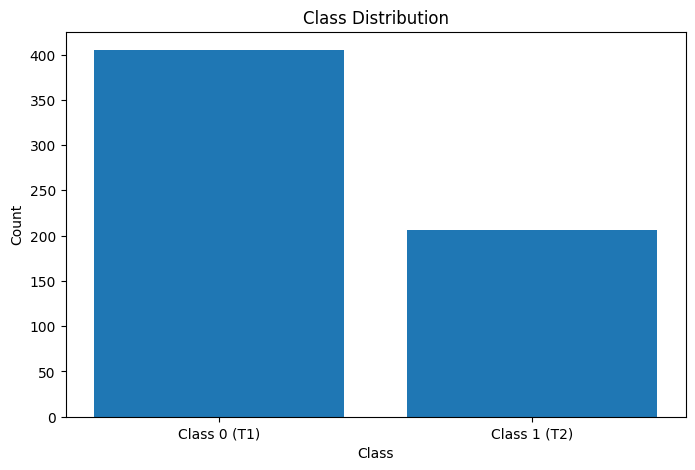

Class weights: {0: np.float64(0.7393939393939394), 1: np.float64(1.5443037974683544)}


In [6]:
# Plot class distribution
plt.figure(figsize=(8, 5))
plt.bar(['Class 0 (T1)', 'Class 1 (T2)'], counts)
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
if not os.path.exists('./eeg_data'):
    os.makedirs('./eeg_data')
plt.savefig('./eeg_data/class_distribution.png')
print("Saved class distribution plot to ./eeg_data/class_distribution.png")
plt.show()

# Transpose X to match LSTM input shape (n_samples, n_timesteps, n_features)
X = np.transpose(X, (0, 2, 1))  # Changes (n_epochs, n_channels, n_times) to (n_epochs, n_times, n_channels)

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Compute class weights for imbalance
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(enumerate(class_weights))
print(f"Class weights: {class_weight_dict}")

In [7]:
# Define function to build the model for hyperparameter tuning
def build_model(hp):
    model = Sequential()
    # Tune the number of LSTM units
    model.add(LSTM(
        units=hp.Int('units', min_value=32, max_value=128, step=32),
        input_shape=(X.shape[1], X.shape[2]),
        kernel_regularizer='l2'  # Add L2 regularization
    ))
    # Tune the dropout rate
    model.add(Dropout(hp.Float('dropout', min_value=0.2, max_value=0.5, step=0.1)))
    model.add(Dense(1, activation='sigmoid'))

    # Tune the learning rate
    learning_rate = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log')
    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

In [9]:
# Initialize the tuner
tuner = kt.Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=20,
    factor=3,
    directory='my_dir',
    project_name='lstm_tuning'
)

# Define early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

# Search for the best hyperparameters
tuner.search(
    X_train, y_train,
    epochs=20,
    batch_size=32,  # We'll tune batch size separately
    validation_data=(X_test, y_test),
    callbacks=[early_stopping],
    class_weight=class_weight_dict
)

# Get the best model
best_model = tuner.get_best_models(num_models=1)[0]
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]  # Fixed: num_models -> num_trials

# Print the best hyperparameters
print("Best Hyperparameters:")
print(f"Number of LSTM units: {best_hyperparameters.get('units')}")
print(f"Dropout rate: {best_hyperparameters.get('dropout')}")
print(f"Learning rate: {best_hyperparameters.get('learning_rate')}")

# Train the best model with early stopping
history = best_model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping],
    class_weight=class_weight_dict
)

# Evaluate the model
loss, accuracy = best_model.evaluate(X_test, y_test)
print(f"\nTest loss: {loss:.4f}")
print(f"Test accuracy: {accuracy:.4f}")
print(f"Train accuracy: {history.history['accuracy'][-1]:.4f}")

Reloading Tuner from my_dir/lstm_tuning/tuner0.json
Best Hyperparameters:
Number of LSTM units: 32
Dropout rate: 0.30000000000000004
Learning rate: 0.0010412916769249282
Epoch 1/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - accuracy: 0.5946 - loss: 1.1722 - val_accuracy: 0.6341 - val_loss: 1.1229
Epoch 2/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.5931 - loss: 1.1122 - val_accuracy: 0.6179 - val_loss: 1.0568
Epoch 3/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.6172 - loss: 1.0272 - val_accuracy: 0.5854 - val_loss: 1.0115
Epoch 4/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.6134 - loss: 0.9763 - val_accuracy: 0.6179 - val_loss: 0.9645
Epoch 5/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.6540 - loss: 0.9030 - val_accuracy: 0.6260 - val_loss: 0.9277
Epoch 6/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.6604 - loss: 0.8660 - val_accuracy: 0.6098 - val_loss: 0.9026
Epoch 7/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.630

Saved training history plot to ./eeg_data/training_history.png


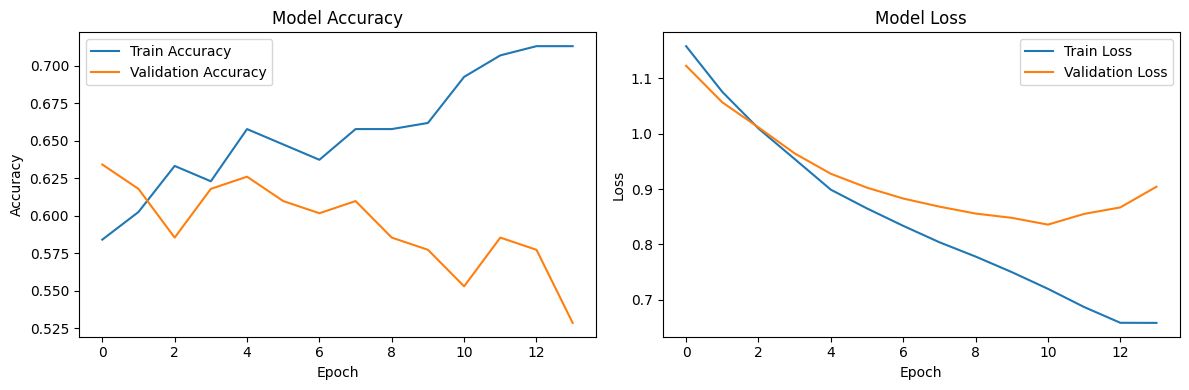

In [10]:
# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.savefig('./eeg_data/training_history.png')
print("Saved training history plot to ./eeg_data/training_history.png")8
plt.show()
